In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import math as math
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn import preprocessing

C:\Users\16192\miniconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [30]:
#reading in CO hotspot with features
#classified into COs and CO hotspots
df = pd.read_csv('final_COhotspot_single_CO_withrate_v4.bed', sep='\t')
df.head()
df.columns = ["chrom", "start", "end", "Occupancy", "CG%", "CHG%", "Type", "Indel Density", "distCent", "distTelo", "distProm", "MLH3", "SNP_Density", "Rate"]

#calculating rate as a function of length of the CO interval
df['Rate2'] = df['Rate']/(df['end']-df['start'])
display(df)
len(df.index)

,chrom,start,end,Occupancy,CG%,CHG%,Type,Indel Density,distCent,distTelo,distProm,MLH3,SNP_Density,Rate,Rate2
0,3,603603,617270,0.017920,85.973217,64.489587,single_CO,0.006366,87782730.0,603603,18,19,0.020121,1,0.000073
1,6,664320,666471,0.026094,37.164453,24.893589,single_CO,0.049279,31583529.0,664320,12,14,0.031613,1,0.000465
2,9,740745,742306,NaN,13.445771,20.323887,single_CO,0.033953,33407694.0,740745,15,16,0.040359,1,0.000641
3,3,751490,762638,0.016145,64.674881,38.162263,single_CO,0.022156,87637362.0,751490,23,21,0.021259,1,0.000090
4,3,753234,763264,0.015044,67.045717,41.845381,single_CO,0.016451,87636736.0,753234,24,21,0.020937,1,0.000100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7215,1,300940464,300954657,0.016153,24.364555,13.798589,Hotspots,0.018460,173940464.0,6101253,6584,4637,0.038751,10,0.000705
7216,1,301293728,301303332,0.022078,20.213609,2.351296,Hotspots,0.013536,174293728.0,5747989,6603,4650,0.032591,6,0.000625
7217,1,304511350,304526834,0.012868,37.247137,27.070728,Hotspots,0.021183,177511350.0,2530367,6720,4712,0.039848,7,0.000452
7218,1,305013942,305020232,0.029454,8.816116,0.267764,Hotspots,0.017011,178013942.0,2027775,6741,4721,0.023847,20,0.003180


7220

In [4]:
#dealing with missing data, usually as NA
df.replace('NA', 'NaN', regex = True, inplace = True)
df.head()

,chrom,start,end,Occupancy,CG%,CHG%,Type,Indel Density,distCent,distTelo,distProm,MLH3,SNP_Density,Rate,Rate2
0,3,603603,617270,0.017920,85.973217,64.489587,single_CO,0.006366,87782730.0,603603,18,19,0.020121,1,0.000073
1,6,664320,666471,0.026094,37.164453,24.893589,single_CO,0.049279,31583529.0,664320,12,14,0.031613,1,0.000465
2,9,740745,742306,NaN,13.445771,20.323887,single_CO,0.033953,33407694.0,740745,15,16,0.040359,1,0.000641
3,3,751490,762638,0.016145,64.674881,38.162263,single_CO,0.022156,87637362.0,751490,23,21,0.021259,1,0.000090
4,3,753234,763264,0.015044,67.045717,41.845381,single_CO,0.016451,87636736.0,753234,24,21,0.020937,1,0.000100


In [5]:
#split into independent and dependent data
#predict col vs columns we use to predict
#y = want to predict
#X = columns we use to predict
X = df.drop(['Type','chrom','start', 'end','SNP_Density','Rate','Rate2'], axis = 1).copy()
y = df['Rate2'].copy()

#to check it looks right
X.head()

,Occupancy,CG%,CHG%,Indel Density,distCent,distTelo,distProm,MLH3
0,0.017920,85.973217,64.489587,0.006366,87782730.0,603603,18,19
1,0.026094,37.164453,24.893589,0.049279,31583529.0,664320,12,14
2,NaN,13.445771,20.323887,0.033953,33407694.0,740745,15,16
3,0.016145,64.674881,38.162263,0.022156,87637362.0,751490,23,21
4,0.015044,67.045717,41.845381,0.016451,87636736.0,753234,24,21


In [97]:
#log transformation of data
numerics = ['int64','float64']
for c in [c for c in X.columns if X[c].dtype in numerics]:
    X[c] = np.log10(X[c])

divide by zero encountered in log10


In [7]:
#One hot encoding: categorical splitting i.e. with 0 or 1 for each categority subtype
#tells us whether float or categorical
#this should all be float!
X.dtypes

Occupancy        float64
CG%              float64
CHG%             float64
Indel Density    float64
distCent         float64
distTelo           int64
distProm           int64
MLH3               int64
dtype: object

In [8]:
#split into training and testing set
#how many cos vs hotspots? need to stratify
sum(df['Rate'] == 1) / sum(df['Rate'] > 1)
#more single COs than hotspots, ~17% are hotspots
#use scale_pos_weight = 0.1712 instead!
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100)

12.938223938223938

In [20]:
#making testing and training
#leave 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [21]:
#take out NA and Inf from datasets
X_train = X_train[~X_train.isin([np.nan, np.inf, -np.inf]).any(1)]
X_test = X_test[~X_test.isin([np.nan, np.inf, -np.inf]).any(1)]

len(X_train)

5331

In [22]:
#filter y based on whats left in X
y_train = y_train[y_train.index.isin(X_train.index)]
y_test = y_test[y_test.index.isin(X_test.index)]

5331

In [23]:
crossover_xgb = xgb.XGBRegressor(objective='reg:squarederror', seed = 100)

crossover_xgb.fit(X_train, y_train, eval_set = [(X_test, y_test)])

[0]	validation_0-rmse:0.34975
[1]	validation_0-rmse:0.24484
[2]	validation_0-rmse:0.17139
[3]	validation_0-rmse:0.11998
[4]	validation_0-rmse:0.08399
[5]	validation_0-rmse:0.05879
[6]	validation_0-rmse:0.04116
[7]	validation_0-rmse:0.02881
[8]	validation_0-rmse:0.02017
[9]	validation_0-rmse:0.01413
[10]	validation_0-rmse:0.00990
[11]	validation_0-rmse:0.00695
[12]	validation_0-rmse:0.00489
[13]	validation_0-rmse:0.00346
[14]	validation_0-rmse:0.00248
[15]	validation_0-rmse:0.00181
[16]	validation_0-rmse:0.00136
[17]	validation_0-rmse:0.00109
[18]	validation_0-rmse:0.00092
[19]	validation_0-rmse:0.00083
[20]	validation_0-rmse:0.00078
[21]	validation_0-rmse:0.00075
[22]	validation_0-rmse:0.00074
[23]	validation_0-rmse:0.00074
[24]	validation_0-rmse:0.00073
[25]	validation_0-rmse:0.00073
[26]	validation_0-rmse:0.00073
[27]	validation_0-rmse:0.00073
[28]	validation_0-rmse:0.00073
[29]	validation_0-rmse:0.00073
[30]	validation_0-rmse:0.00073
[31]	validation_0-rmse:0.00073
[32]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [27]:
#identifying R2 and RMSE of the model with prediction
crossover_xgb.fit(X_train, y_train)

y_pred = crossover_xgb.predict(X_test)
y_true = y_test

MSE = mse(y_true, y_pred)
RMSE = np.sqrt(MSE)

R_squared = r2_score(y_true, y_pred)
print(R_squared)
print(RMSE)

0.3075167216834154
0.0007329342372709861


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Model error = 0.05798241347307659
0:[CG%<0.0257865004] yes=1,no=2,missing=1,gain=0.000846936833,cover=7220
	1:[distCent<119081680] yes=3,no=4,missing=3,gain=0.000230760663,cover=121
		3:[Occupancy<0.0238230005] yes=7,no=8,missing=7,gain=0.000173569191,cover=58
			7:leaf=0.00403541699,cover=54
			8:leaf=0.010862316,cover=4
		4:[CHG%<13.333334] yes=9,no=10,missing=10,gain=4.37378621e-05,cover=63
			9:leaf=0.00147158024,cover=57
			10:leaf=0.00431006122,cover=6
	2:[Occupancy<0.0492454991] yes=5,no=6,missing=6,gain=0.000233652885,cover=7099
		5:[Indel Density<0.0843136013] yes=11,no=12,missing=11,gain=0.000188751961,cover=6560
			11:leaf=0.000344758126,cover=6559
			12:leaf=0.0140845068,cover=1
		6:[Indel Density<0.000199952017] yes=13,no=14,missing=13,gain=7.02030375e-05,cover=539
			13:leaf=0.00476142904,cover=5
			14:leaf=0.000996847637,cover=534



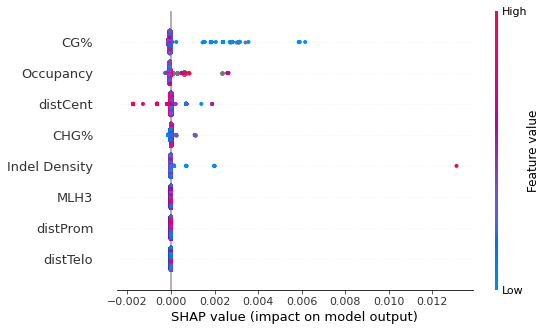

In [25]:
#SHAP models to look at which features are most important
import shap

#making model with one tree
Xd = xgb.DMatrix(X, label=y)
model = xgb.train({
    'eta':1, 'max_depth':3, 'base_score': 0, "lambda": 0
}, Xd, 1)
print("Model error =", np.linalg.norm(y-model.predict(Xd)))
print(model.get_dump(with_stats=True)[0])

# make sure the SHAP values add up to marginal predictions
pred = model.predict(Xd, output_margin=True)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xd)
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

shap.summary_plot(shap_values, X)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

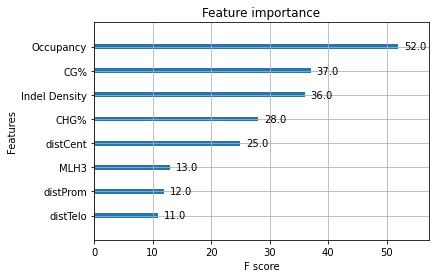

In [28]:
#top 10 most important features
plot_importance(crossover_xgb, max_num_features=10)